# Comparison between real distributions and synthetic distributions

In [74]:
import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance
from scipy.stats import chisquare, chi2_contingency

import matplotlib.pyplot as plt
import math
from bokeh.io import push_notebook, show, output_notebook, export_png, export_svgs
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.transform import dodge
output_notebook()

Loading BokehJS ...

Choice of the synthetic database

In [75]:
conn = sqlite3.connect("snds_Paris_db0.db")
dpts=["75","77","78","91","92","93","94","95"]

## Analysis of the synthetic population structure

We start by loading the real population structure from raw data.

In [76]:
import os.path
outdir="../datarep"
pop_saq = pd.read_csv( os.path.join(outdir,"pop.csv") )
pop_tot = pop_saq['pop'].sum()
pop_brittany_tot = pop_saq[pop_saq.RR==11]['pop'].sum()

/home/tguyet/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


And new, we extract the synthetic population structure from the database

In [77]:
# On effectue une requête pour extraire les informations sur la population
df = pd.read_sql_query("SELECT BEN_SEX_COD, BEN_RES_DPT, BEN_NAI_ANN, count(*) FROM IR_BEN_R GROUP BY BEN_SEX_COD, BEN_RES_DPT, BEN_NAI_ANN;", conn)
df.rename(columns={'BEN_SEX_COD':'sex','BEN_RES_DPT':'dpt', 'count(*)':'count'}, inplace=True)
df['age']=2019-df.BEN_NAI_ANN
df=df[['sex','dpt','age','count']]

### Comparison of ages

In [78]:
df_age=df.groupby(["age"]).agg({"count":"sum"}).reset_index()
df_age.plot(x='age',y="count")

In [79]:
# Ages are grouped in 5-years group to have the same structure as the real data
age_bins=list(np.arange(0,100,5))
age_bins.append(125)
df_age['bin']=pd.cut(df_age.age,bins=age_bins,include_lowest=True, labels=age_bins[:-1])
df_age_agg=df_age.groupby('bin').agg({"count":"sum"}).reset_index()
df_age_agg.head()

bin  count
0   0    673
1   5    536
2  10    505
3  15    526
4  20    591

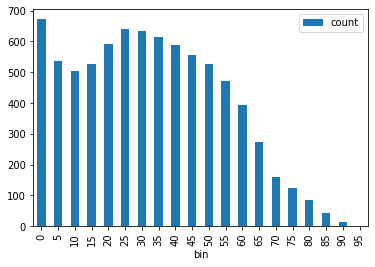

In [80]:
df_age_agg.plot.bar(x='bin',y="count")

In [81]:
#real population (selection of the two generated populations)
pop_seq_dpt=pop_saq[ pop_saq['dpt'].isin(dpts) ].groupby(['age']).agg({'pop':'sum'}).reset_index()
real_pop_size=sum(pop_seq_dpt['pop'])

In [82]:
#the number of patients of the real population is proportionnaly scaled to the level of the synthetic database
ratio = sum(df_age_agg['count'])/sum(pop_seq_dpt['pop'])
pop_seq_dpt['pop'] *= ratio

In [83]:
# We draw a graph to compare the two distributions
pops=pd.merge(pop_seq_dpt, df_age_agg, left_on="age", right_on="bin")[['age','pop','count']].rename(columns={'count':'pop_sim'})

p = figure(title=None, x_range=(-1,96), y_range=(0,700), plot_width=600, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('age', -0.5, range=p.x_range), top='pop', source=ColumnDataSource(pops), width=1,legend_label="Real")
p.vbar(x=dodge('age', +0.5, range=p.x_range), top='pop_sim', fill_color="orange", width=1, source=ColumnDataSource(pops),legend_label="Synth")
p.legend.location = "top_right"
#p.xaxis.axis_label = 'ATC codes'
p.yaxis.axis_label = 'Nb'
show(p)

In [84]:
# Compute of the total absolute difference between the two distributions
print( np.sum(np.abs(pops['pop_sim']-pops['pop']))/np.sum(pops['pop']) )
# Compute of the mean absolute difference between the two distributions
print( np.mean(np.abs(pops['pop_sim']-pops['pop'])/pops['pop']) )

0.11553265535570202
0.23691327258562098


### Kolmogorov-Smirnov test
The Kolmogorov-Smirnov test tests whether two one-dimensional distributions differ. 

$D_{n,m}=\max(F_r(x),F_s(x))$ where $F_r$ (resp. $F_s$) is the cumulative distribution function of the real population (resp. synthetic population), and $m$, $n$ are the population sizes (number of samples).

the null hypothesis is rejected at level $\alpha$ (ie it really differs) if the difference is above a critical value:
$$D_{n,m}>c(\alpha)\sqrt{\frac{n + m}{n\cdot m}}$$

where $c\left(\alpha\right)=\sqrt{-\ln\left(\tfrac{\alpha}{2}\right)\cdot \tfrac{1}{2}}$.

<br>

In the following, we use $n=m$ equals to the size of the sampled database. 


In [85]:
# Cumulative distribution functions
P_r = pops['pop'].to_numpy()/pops['pop'].sum()
CDF_r = np.cumsum(P_r)
P_s = pops['pop_sim'].to_numpy()/pops['pop_sim'].sum()
CDF_s = np.cumsum(P_s)

In [86]:
#Implementation of the Kolmogorov-Smirnov test
alpha=0.05 #95% critical value 
m=sum(df_age_agg['count'])
n=real_pop_size
statistic=np.max(np.abs(CDF_r-CDF_s))
critical_value= np.sqrt(-np.log(alpha/2)*0.5)*np.sqrt( (n+m)/(m*m) )
print(statistic>critical_value)
print(statistic)
print(critical_value)

False
0.057766327677850615
0.5939627444557788


We conclude that the distributions are not significantly different (p<0.05).

### KL Divergence / JS divergence

Kullback-Leibler (KL) Divergence is a measure based on entropy to compare two distributions $P$ and $P$. The Jensen-Shannon is the symmetric version of KL divergence.

$$D_\text{KL}(P \parallel Q) = \sum_{x\in\mathcal{X}} P(x) \log\left(\frac{P(x)}{Q(x)}\right)$$

and 
$$D_\text{JS}(P \parallel Q) = \frac{1}{2}D_\text{KL}(P \parallel Q) + \frac{1}{2}D_\text{KL}(Q \parallel P)$$

In [87]:
# calculate the kl divergence
def kl_divergence(p, q):
    return sum(p[i] * np.log(p[i]/q[i])/np.log(2) for i in range(len(p)))
 
# calculate the js divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

Then, we simply have to apply the function on our distributions



In [88]:
js_divergence(pops['pop'].to_numpy()/pops['pop'].sum(), pops['pop_sim'].to_numpy()/pops['pop_sim'].sum())

<ipython-input-87-953c0830fea7>:3: RuntimeWarning: divide by zero encountered in log
  return sum(p[i] * np.log(p[i]/q[i])/np.log(2) for i in range(len(p)))
<ipython-input-87-953c0830fea7>:3: RuntimeWarning: invalid value encountered in double_scalars
  return sum(p[i] * np.log(p[i]/q[i])/np.log(2) for i in range(len(p)))


nan

### Wasserstein distance (Earth's mover distance)

In [89]:
wasserstein_distance(pops['pop'].to_numpy()/pops['pop'].sum(), pops['pop_sim'].to_numpy()/pops['pop_sim'].sum())

0.005776632767785094

### We add the national population statistics

In [90]:
#real national population
pop_seq_national=pop_saq.groupby(['age']).agg({'pop':'sum'}).reset_index()
real_pop_size_national=sum(pop_seq_dpt['pop'])
#the number of patients of the real population is proportionnaly scaled to the level of the synthetic database
pop_seq_national['pop'] *= sum(df_age_agg['count'])/sum(pop_seq_national['pop'])
#pop_seq_national.plot.bar(x="age",y="pop")

In [91]:
# We draw a graph to compare the three distributions
pops=pd.merge(pop_seq_dpt, pop_seq_national, on="age").rename(columns={'pop_x':'real_brittany', 'pop_y':'real_national'})
pops=pd.merge(pops, df_age_agg, left_on="age", right_on="bin")[['age','real_brittany','real_national','count']].rename(columns={'count':'pop_sim'})

p = figure(title=None, x_range=(-1,96), y_range=(0,700), plot_width=600, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('age', -0.9, range=p.x_range), top='real_brittany', source=ColumnDataSource(pops), width=1,legend_label="Real")
p.vbar(x=dodge('age', -0, range=p.x_range), top='real_national', fill_color="purple", source=ColumnDataSource(pops), width=1,legend_label="Real (National)")
p.vbar(x=dodge('age', +0.9, range=p.x_range), top='pop_sim', fill_color="orange", width=1, source=ColumnDataSource(pops),legend_label="Synth")
p.legend.location = "top_right"
p.yaxis.axis_label = 'Nb'
show(p)


## Now ... the same for genders


In [92]:
df_sex=df.groupby(["sex"]).agg({"count":"sum"}).reset_index()
df_sex

sex  count
0    1   3832
1    2   4124

In [93]:
pop_sex_dpt=pop_saq[pop_saq['dpt'].isin(dpts)].groupby(['sex']).agg({'pop':'sum'}).reset_index()
pop_sex_dpt

sex           pop
0    1  5.848590e+06
1    2  6.250647e+06

In [94]:
#same proportion for figures
pop_sex_dpt['pop'] = ratio*pop_sex_dpt['pop']
pops_sex=pd.merge(pop_sex_dpt,df_sex,on='sex').rename(columns={"count":"pop_sim"})

In [95]:
pops_sex['sex']=pops_sex['sex'].astype("str").str.replace("1","M").replace("2","F")
p = figure(title=None, x_range=pops_sex['sex'].to_numpy(), plot_width=400, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('sex', -0.2, range=p.x_range), top='pop', source=ColumnDataSource(pops_sex), width=0.4,legend_label="Real")
p.vbar(x=dodge('sex', +0.2, range=p.x_range), top='pop_sim', fill_color="orange", width=0.4, source=ColumnDataSource(pops_sex),legend_label="Synth")
p.legend.location = "bottom_right"
#p.xaxis.axis_label = 'ATC codes'
p.yaxis.axis_label = 'Nb'
show(p)

### Quantitiative Comparisons

We perform $\chi^2$ test, and then we compute some distances.

In [96]:
chisquare(pops_sex['pop_sim'].to_numpy(), pops_sex['pop'].to_numpy())

Power_divergenceResult(statistic=0.09601017158256114, pvalue=0.7566711624342122)

Here, the p-value is >0.05, then the null hypotheses (i.e. $H_0$: the two samples have the distribution) can not be rejected.

We simply compute the JS divergence in this case (not a continuous distribution)

In [97]:
js_divergence(pops_sex['pop'].to_numpy()/pops_sex['pop'].sum(), pops_sex['pop_sim'].to_numpy()/pops_sex['pop_sim'].sum())

2.1765002276056492e-06

In [98]:
wasserstein_distance(pops_sex['pop'].to_numpy()/pops_sex['pop'].sum(), pops_sex['pop_sim'].to_numpy()/pops_sex['pop_sim'].sum())

0.0017359664495833482

### Mean values of KL divergence

In [99]:
age_bins=list(np.arange(0,100,5))
age_bins.append(125)

js_age_vals=[]
js_sex_vals=[]
for i in range(10):
    conni = sqlite3.connect("snds_Brittany_db%d.db"%i)
    df = pd.read_sql_query("SELECT BEN_SEX_COD, BEN_RES_DPT, BEN_NAI_ANN, count(*) FROM IR_BEN_R GROUP BY BEN_SEX_COD, BEN_RES_DPT, BEN_NAI_ANN;", conni)
    df.rename(columns={'BEN_SEX_COD':'sex','BEN_RES_DPT':'dpt', 'count(*)':'count'}, inplace=True)
    df['age']=2019-df.BEN_NAI_ANN
    df=df[['sex','dpt','age','count']]
    
    #ages
    df['bin']=pd.cut(df.age,bins=age_bins,include_lowest=True, labels=age_bins[:-1])
    df_age_agg=df.groupby('bin').agg({"count":"sum"}).reset_index()
    
    pop_seq_dpt=pop_saq[ pop_saq['dpt'].isin(dpts) ].groupby(['age']).agg({'pop':'sum'}).reset_index()
    
    pops=pd.merge(pop_seq_dpt, df_age_agg, left_on="age", right_on="bin")[['age','pop','count']].rename(columns={'count':'pop_sim'})
    js=js_divergence(pops['pop'].to_numpy()/pops['pop'].sum(), pops['pop_sim'].to_numpy()/pops['pop_sim'].sum())
    js_age_vals.append(js)
    
    df_sex=df.groupby(["sex"]).agg({"count":"sum"}).reset_index()
    pop_sex_dpt=pop_saq[pop_saq['dpt'].isin(dpts)].groupby(['sex']).agg({'pop':'sum'}).reset_index()
    pops_sex['sex']=pops_sex['sex'].astype("str").str.replace("1","M").replace("2","F")
    js=js_divergence(pops_sex['pop'].to_numpy()/pops_sex['pop'].sum(), pops_sex['pop_sim'].to_numpy()/pops_sex['pop_sim'].sum())
    js_sex_vals.append(js)

    conni.close()
print(js_age_vals)
print("mean: %.2e, var: %.2e"%(np.mean(js_age_vals),np.var(js_age_vals)))
print(js_sex_vals)
print("mean: %.2e, var: %.2e"%(np.mean(js_sex_vals),np.var(js_sex_vals)))

[0.006741627844171028, 0.006127560022309891, 0.006431130976548264, 0.007291353927667791, 0.006145460246880833, 0.006663303394327461, 0.0062860378075277985, 0.006764574865187714, 0.006273649971959372, 0.006643321345356753]
mean: 6.54e-03, var: 1.15e-07
[2.1765002276056492e-06, 2.1765002276056492e-06, 2.1765002276056492e-06, 2.1765002276056492e-06, 2.1765002276056492e-06, 2.1765002276056492e-06, 2.1765002276056492e-06, 2.1765002276056492e-06, 2.1765002276056492e-06, 2.1765002276056492e-06]
mean: 2.18e-06, var: 0.00e+00


## Analysis of the drug distributions

In [100]:
# On effectue une requête pour extraire les informations sur les médicaments (nombres de prescriptions par ATC 3)
# -> là on a les chiffres généré pour 2 départements, sur 1 an
df = pd.read_sql_query("SELECT PHA_ATC_C03, sum(PHA_ACT_QSN) FROM er_pha_f JOIN ir_pha_r ON ir_pha_r.PHA_CIP_C13=er_pha_f.PHA_PRS_C13 GROUP BY PHA_ATC_C03;", conn)
df.rename(columns={'PHA_ATC_C03':'ATC2','sum(PHA_ACT_QSN)':'nb'}, inplace=True)
df

ATC2    nb
0   A01  2609
1   A02  9213
2   A03  4954
3   A04   822
4   A05   178
..  ...   ...
72  S02   635
73  V01    51
74  V03   159
75  V04    92
76  V08   693

[77 rows x 2 columns]

In [101]:
# data for the French population, during a year
data = pd.read_csv("../data/OPEN_MEDIC_2019.zip", header=0, sep=';', encoding="latin_1")[['ATC2','BOITES']]
data = data.groupby("ATC2").agg({'BOITES':'sum'}).reset_index().rename(columns={'BOITES':"nb"})

In [102]:
data.head()

ATC2         nb
0  A01   22941566
1  A02  100746397
2  A03   48505314
3  A04    8452671
4  A05    1954634

In [103]:
#we compute the population proportionality ratio
ratio = sum( df_age_agg['count'] )/pop_tot

In [104]:
df_cmp=pd.merge(data,df,how="left",on='ATC2',suffixes=('','_sim')).fillna(0)
df_cmp['nb'] *= ratio
df_cmp.head()

ATC2           nb  nb_sim
0  A01  1914.922384  2609.0
1  A02  8409.257273  9213.0
2  A03  4048.717142  4954.0
3  A04   705.540716   822.0
4  A05   163.152437   178.0

In [105]:
p = figure(title=None, x_range=df_cmp['ATC2'].to_numpy(), plot_width=1200, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('ATC2', -0.2, range=p.x_range), top='nb_sim', fill_color="orange", width=0.4, source=ColumnDataSource(df_cmp),legend_label="Synth")
p.vbar(x=dodge('ATC2', +0.2, range=p.x_range), top='nb', source=ColumnDataSource(df_cmp), width=0.4,legend_label="Real")
p.legend.location = "top_right"
#p.xaxis.axis_label = 'ATC codes'
p.yaxis.axis_label = 'Nb'
show(p)

### Quantitiative Comparisons

We perform $\chi^2$ test, and then a compute some distances.

In [106]:
chisquare(df_cmp['nb_sim'].to_numpy(), df_cmp['nb'].to_numpy())

Power_divergenceResult(statistic=11978.786690482299, pvalue=0.0)

Here, the p-value is null, then the null hypotheses (i.e. $H_0$: the two samples have the distribution) is rejected.

We now simply compute the JS divergence in this case (not a continuous distribution)

In [107]:
js_divergence(df_cmp['nb'].to_numpy()/df_cmp['nb'].sum(), df_cmp['nb_sim'].to_numpy()/df_cmp['nb_sim'].sum())

<ipython-input-87-953c0830fea7>:3: RuntimeWarning: divide by zero encountered in log
  return sum(p[i] * np.log(p[i]/q[i])/np.log(2) for i in range(len(p)))
<ipython-input-87-953c0830fea7>:3: RuntimeWarning: invalid value encountered in double_scalars
  return sum(p[i] * np.log(p[i]/q[i])/np.log(2) for i in range(len(p)))


nan

In [108]:
wasserstein_distance(df_cmp['nb'].to_numpy()/df_cmp['nb'].sum(), df_cmp['nb_sim'].to_numpy()/df_cmp['nb_sim'].sum())

0.0007680488901518261

In [109]:
# Compute of the total absolute difference between the two distributions
print( np.sum(np.abs(df_cmp['nb_sim']-df_cmp['nb']))/np.sum(df_cmp['nb']) )
# Compute of the mean absolute difference between the two distributions
print( np.mean(np.abs(df_cmp['nb_sim']-df_cmp['nb'])/df_cmp['nb']) )

0.2028970332004138
0.34181052498829567


### Mean KL divergence

In [110]:
data = pd.read_csv("../data/OPEN_MEDIC_2019.zip", header=0, sep=';', encoding="latin_1")[['ATC2','BOITES']]
data = data.groupby("ATC2").agg({'BOITES':'sum'}).reset_index().rename(columns={'BOITES':"nb"})

js_vals=[]
for i in range(10):
    conni = sqlite3.connect("snds_Brittany_db%d.db"%i)
    df = pd.read_sql_query("SELECT PHA_ATC_C03, sum(PHA_ACT_QSN) FROM er_pha_f JOIN ir_pha_r ON ir_pha_r.PHA_CIP_C13=er_pha_f.PHA_PRS_C13 GROUP BY PHA_ATC_C03;", conni)
    df.rename(columns={'PHA_ATC_C03':'ATC2','sum(PHA_ACT_QSN)':'nb'}, inplace=True)
    df_cmp=pd.merge(data,df,how="left",on='ATC2',suffixes=('','_sim')).fillna(0)
    df_cmp=df_cmp[df_cmp['nb_sim']!=0]
    
    js=js_divergence(df_cmp['nb'].to_numpy()/df_cmp['nb'].sum(), df_cmp['nb_sim'].to_numpy()/df_cmp['nb_sim'].sum())
    
    js_vals.append(js)
    conni.close()
print(js_vals)
print("mean: %.2e, var: %.2e"%(np.mean(js_vals),np.var(js_vals)))

[0.004256684087469983, 0.003938747505275751, 0.0040126153389123155, 0.004065690977919667, 0.003942539896471847, 0.004179296044895158, 0.003684526187509506, 0.004086835399582545, 0.003997700157755514, 0.004029162123631213]
mean: 4.02e-03, var: 2.14e-08


In [111]:
df_cmp[df_cmp['nb_sim']!=0]

ATC2         nb  nb_sim
0   A01   22941566  1503.0
1   A02  100746397  7081.0
2   A03   48505314  2970.0
3   A04    8452671   517.0
4   A05    1954634   149.0
..  ...        ...     ...
74  S02    5741148   339.0
75  V01     448942    25.0
76  V03    1403824    96.0
77  V04     520717    33.0
79  V08    6618860   397.0

[76 rows x 3 columns]

### Comparison with the drugs distribution in Brittany only

In [112]:
# data for the French population, during a year
data = pd.read_csv("../data/OPEN_MEDIC_2019.zip", header=0, sep=';', encoding="latin_1")[['ATC2','BOITES','age',
       'sexe', 'BEN_REG']]

In [113]:
national_count = data.groupby("ATC2").agg({'BOITES':'sum'}).reset_index().rename(columns={'BOITES':"nb"})
brittany_count = data[ data.BEN_REG==11 ].groupby("ATC2").agg({'BOITES':'sum'}).reset_index().rename(columns={'BOITES':"nb"})

In [114]:
#we compute the population proportionality ratio
df_cmp_nat=pd.merge(national_count,df,how="left",on='ATC2',suffixes=('','_sim')).fillna(0)
df_cmp_nat['nb'] *= sum( df_age_agg['count'] )/pop_tot
df_cmp_nat.head()

ATC2           nb  nb_sim
0  A01  1914.922384  1503.0
1  A02  8409.257273  7081.0
2  A03  4048.717142  2970.0
3  A04   705.540716   517.0
4  A05   163.152437   149.0

In [115]:
#we compute the population proportionality ratio
df_cmp_brittany=pd.merge(df_cmp_nat, brittany_count,how="left",on='ATC2',suffixes=('','_brit')).fillna(0)
df_cmp_brittany['nb_brit'] *= sum( df_age_agg['count'] )/pop_brittany_tot
df_cmp_brittany.head()

ATC2           nb  nb_sim      nb_brit
0  A01  1914.922384  1503.0  1931.169804
1  A02  8409.257273  7081.0  7437.231289
2  A03  4048.717142  2970.0  3638.234840
3  A04   705.540716   517.0   613.524880
4  A05   163.152437   149.0   141.609599

In [116]:
p = figure(title=None, x_range=df_cmp_brittany['ATC2'].to_numpy(), plot_width=1200, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('ATC2', -0.25, range=p.x_range), top='nb_sim', fill_color="orange", width=0.3, source=ColumnDataSource(df_cmp_brittany),legend_label="Synth")
p.vbar(x=dodge('ATC2', -0, range=p.x_range), top='nb_brit', fill_color="purple", width=0.3, source=ColumnDataSource(df_cmp_brittany),legend_label="Real Brittany")
p.vbar(x=dodge('ATC2', +0.25, range=p.x_range), top='nb', source=ColumnDataSource(df_cmp_brittany), width=0.3,legend_label="Real National")
p.legend.location = "top_right"
#p.xaxis.axis_label = 'ATC codes'
p.yaxis.axis_label = 'Nb'
show(p)

### Comparison of distribution per sex

In [117]:
count_male = data[ (data.BEN_REG==11) & (data.sexe==1)].groupby("ATC2").agg({'BOITES':'sum'}).reset_index().rename(columns={'BOITES':"nb"})
count_male['nb'] *= sum( df_age_agg['count'] )/pop_brittany_tot
count_female = data[ (data.BEN_REG==11) & (data.sexe==2)].groupby("ATC2").agg({'BOITES':'sum'}).reset_index().rename(columns={'BOITES':"nb"})
count_female['nb'] *= sum( df_age_agg['count'] )/pop_brittany_tot

In [118]:
# Extract number of medics per sex
df = pd.read_sql_query("""SELECT PHA_ATC_C03, BEN_SEX_COD, sum(PHA_ACT_QSN) 
		FROM er_prs_f JOIN er_pha_f ON 
			er_prs_f.DCT_ORD_NUM = er_pha_f.DCT_ORD_NUM AND
            er_prs_f.FLX_DIS_DTD = er_pha_f.FLX_DIS_DTD AND
            er_prs_f.FLX_EMT_NUM = er_pha_f.FLX_EMT_NUM AND
            er_prs_f.FLX_EMT_ORD = er_pha_f.FLX_EMT_ORD AND
            er_prs_f.FLX_EMT_TYP = er_pha_f.FLX_EMT_TYP AND
            er_prs_f.FLX_TRT_DTD = er_pha_f.FLX_TRT_DTD AND
            er_prs_f.ORG_CLE_NUM = er_pha_f.ORG_CLE_NUM AND
            er_prs_f.PRS_ORD_NUM = er_pha_f.PRS_ORD_NUM AND
            er_prs_f.REM_TYP_AFF = er_pha_f.REM_TYP_AFF 
		JOIN ir_pha_r ON 
			ir_pha_r.PHA_CIP_C13=er_pha_f.PHA_PRS_C13 
		GROUP BY PHA_ATC_C03, BEN_SEX_COD;""", conn)
df.rename(columns={'PHA_ATC_C03':'ATC2','sum(PHA_ACT_QSN)':'nb', "BEN_SEX_COD":'sex'}, inplace=True)

In [119]:
p = figure(title=None, x_range=np.unique(df['ATC2'][(df.ATC2>="L03") & (df.ATC2<="S01")]), plot_width=600, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('ATC2', -0.22, range=p.x_range), hatch_weight=0.6, hatch_pattern='right_diagonal_line', top='nb', fill_color="orange", width=0.22, source=ColumnDataSource(count_male),legend_label="Synth (Male)")
p.vbar(x=dodge('ATC2', 0, range=p.x_range), hatch_weight=0.6, hatch_pattern='right_diagonal_line', top='nb', source=ColumnDataSource(df[df.sex==1]), width=0.22,legend_label="Real (Male)")
p.vbar(x=dodge('ATC2', +0.22, range=p.x_range), top='nb', fill_color="orange", width=0.22, source=ColumnDataSource(count_female),legend_label="Synth (Female)")
p.vbar(x=dodge('ATC2', +0.44, range=p.x_range), top='nb', source=ColumnDataSource(df[df.sex==2]), width=0.22,legend_label="Real (Female)")
p.legend.location = "top_right"
#p.xaxis.axis_label = 'ATC codes'
p.yaxis.axis_label = 'Nb'
show(p)

### Comparison of the distributions with respect to ages

In [120]:
# Extract number of medics per sex
df = pd.read_sql_query("""SELECT PHA_ATC_C03, BEN_SEX_COD, BEN_NAI_ANN, sum(PHA_ACT_QSN) 
		FROM er_prs_f JOIN er_pha_f ON 
			er_prs_f.DCT_ORD_NUM = er_pha_f.DCT_ORD_NUM AND
            er_prs_f.FLX_DIS_DTD = er_pha_f.FLX_DIS_DTD AND
            er_prs_f.FLX_EMT_NUM = er_pha_f.FLX_EMT_NUM AND
            er_prs_f.FLX_EMT_ORD = er_pha_f.FLX_EMT_ORD AND
            er_prs_f.FLX_EMT_TYP = er_pha_f.FLX_EMT_TYP AND
            er_prs_f.FLX_TRT_DTD = er_pha_f.FLX_TRT_DTD AND
            er_prs_f.ORG_CLE_NUM = er_pha_f.ORG_CLE_NUM AND
            er_prs_f.PRS_ORD_NUM = er_pha_f.PRS_ORD_NUM AND
            er_prs_f.REM_TYP_AFF = er_pha_f.REM_TYP_AFF 
		JOIN ir_pha_r ON 
			ir_pha_r.PHA_CIP_C13=er_pha_f.PHA_PRS_C13 
		GROUP BY PHA_ATC_C03, BEN_SEX_COD, BEN_NAI_ANN;""", conn)
df.rename(columns={'PHA_ATC_C03':'ATC2','sum(PHA_ACT_QSN)':'nb', "BEN_SEX_COD":'sex'}, inplace=True)
df['age'] = 2019-df['BEN_NAI_ANN'] #approximated patient age
del(df['BEN_NAI_ANN'],df['sex'])
#group the number of drugs deliveries per 20-year age classes
#cuttings=pd.cut(df["age"], np.arange(0, 100, 20))
#cuttings=pd.cut(df["age"], [-1,19,59,99], include_lowest=True, right=False)
cuttings=pd.cut(df["age"], [0,20,60,99], include_lowest=True, right=False)
df = df.groupby(["ATC2", cuttings]).agg({'nb':'sum'}).reset_index()
df['age'] = df['age'].astype(str)
df.head()

ATC2       age      nb
0  A01   [0, 20)   316.0
1  A01  [20, 60)  1677.0
2  A01  [60, 99)   616.0
3  A02   [0, 20)   336.0
4  A02  [20, 60)  4646.0

In [121]:
#cuttings=pd.cut(data[ (data.BEN_REG==11)]["age"], [-1,19,59,99])
cuttings=pd.cut(data[ (data.BEN_REG==11)]["age"], [0,20,60,99], include_lowest=True, right=False)
count = data[ (data.BEN_REG==11)].groupby(["ATC2",cuttings]).agg({'BOITES':'sum'}).reset_index().rename(columns={'BOITES':"nb"})
#count.dropna(inplace=True)
count['nb'] *= sum( df_age_agg['count'] )/pop_brittany_tot
count['age'] = count['age'].astype(str)
count.head()

ATC2       age           nb
0  A01   [0, 20)   202.644806
1  A01  [20, 60)  1154.840488
2  A01  [60, 99)   573.656626
3  A02   [0, 20)   239.141414
4  A02  [20, 60)  3185.989933

In [122]:
p = figure(title=None, x_range=np.unique(count['ATC2'][(count.ATC2>="L03") & (count.ATC2<="S01")]), plot_width=600, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('ATC2', -0.3, range=p.x_range), hatch_weight=0.6, hatch_pattern='right_diagonal_line', top='nb', fill_color="orange", width=0.17, source=ColumnDataSource(count[count.age=="[0, 20)"]),legend_label="Synth ([0,20])")
p.vbar(x=dodge('ATC2', -0.15, range=p.x_range), top='nb', fill_color="orange", width=0.17, source=ColumnDataSource(count[count.age=="[20, 60)"]),legend_label="Synth ([20,60])")
p.vbar(x=dodge('ATC2', 0, range=p.x_range), hatch_weight=0.6, hatch_pattern='left_diagonal_line', top='nb', fill_color="orange", width=0.17, source=ColumnDataSource(count[count.age=="[60, 99)"]),legend_label="Synth ([60,99])")
p.vbar(x=dodge('ATC2', 0.15, range=p.x_range), hatch_weight=0.6, hatch_pattern='right_diagonal_line', top='nb', width=0.17, source=ColumnDataSource(df[df.age=="[0, 20)"]),legend_label="Real ([0,20])")
p.vbar(x=dodge('ATC2', 0.3, range=p.x_range), top='nb', width=0.17, source=ColumnDataSource(df[df.age=="[20, 60)"]),legend_label="Real ([20,60])")
p.vbar(x=dodge('ATC2', 0.45, range=p.x_range), hatch_weight=0.6, hatch_pattern='left_diagonal_line', top='nb', width=0.17, source=ColumnDataSource(df[df.age=="[60, 99)"]),legend_label="Real ([60,99])")

p.legend.location = "top_right"
#p.xaxis.axis_label = 'ATC codes'
p.yaxis.axis_label = 'Nb'
show(p)

## Procedures

In [123]:
# Database query to extract procedures from the synthetic database
df = pd.read_sql_query("SELECT CAM_PRS_IDE, CAM_PRS_RGT, count(*) FROM er_cam_f JOIN ir_ccam_v63 ON er_cam_f.CAM_PRS_IDE=ir_ccam_v63.CAM_PRS_IDE_COD GROUP BY CAM_PRS_IDE, CAM_PRS_RGT;", conn)
df.rename(columns={'CAM_PRS_IDE':'ccam','CAM_PRS_RGT':'grp','count(*)':'nb'}, inplace=True)
df.head()

ccam  grp  nb
0  ACQH002  ADI   1
1  ACQH003  ADI  13
2  ACQH004  ADI   1
3  ACQJ001  ADI   2
4  ACQJ002  ADI  57

In [124]:
procedures = pd.read_excel("../data/Actes_techniques_de_la_CCAM_en_2016.xls", sheet_name='Panorama des actes CCAM')
procedures.rename(columns={"Code Acte":'ccam',"Code Regroupement":"grp", "Quantité d'actes ":"nb"}, inplace=True)
procedures=procedures.groupby(['ccam',"grp"]).agg({"nb":"sum"}).reset_index()

In [125]:
#selection of procedures that are actually used in our simulation
#procedures=procedures[ (procedures['grp']=="ADC") | (procedures['grp']=="ACO") |(procedures['grp']=="ADA") |(procedures['grp']=="ADE") |(procedures['grp']=="ADI") |(procedures['grp']=="ADT") ]
procedures=procedures[ (procedures['grp']=="ADC") | (procedures['grp']=="ACO") |(procedures['grp']=="ADE") |(procedures['grp']=="ADI") |(procedures['grp']=="ADT") ]
procedures=procedures[ (procedures['ccam'].str[:2]!="HB") ]

In [126]:
procedures.head()

ccam  grp   nb
1  AAFA001  ADC  103
3  AAFA002  ADC  446
5  AAFA003  ADC    9
7  AAFA005  ADC    9
9  AAFA006  ADC    2

In [127]:
procs_tot=procedures.groupby(['ccam']).agg({"nb":"sum"}).reset_index()

In [128]:
procs_tot.head()

ccam   nb
0  AAFA001  103
1  AAFA002  446
2  AAFA003    9
3  AAFA005    9
4  AAFA006    2

In [129]:
procs_tot['nb'] *= ratio

In [130]:
procs_tot.head()

ccam        nb
0  AAFA001  0.008597
1  AAFA002  0.037227
2  AAFA003  0.000751
3  AAFA005  0.000751
4  AAFA006  0.000167

### Comparison of the distribution of procedures per groups

In [131]:
procs_grp=procedures.groupby(['grp']).agg({"nb":"sum"}).reset_index()
procs_grp['nb'] *= ratio

In [132]:
df_grp=df.groupby("grp").agg({"nb":"sum"}).reset_index()

Text(0, 0.5, 'nb')

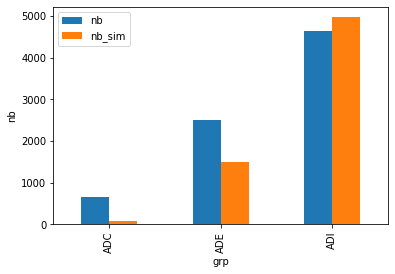

In [133]:
grps=pd.merge(procs_grp, df_grp,on="grp", suffixes=('','_sim'))

fig, axs = plt.subplots()
grps.set_index("grp").plot.bar(ax=axs)
axs.set_ylabel("nb")

In [134]:
procs_ccam=procedures.groupby(['ccam']).agg({"nb":"sum"}).reset_index()
procs_ccam['nb'] *= ratio
#procs_ccam['nb'] = procs_ccam['nb'].astype(int)
df_ccam=df.groupby("ccam").agg({"nb":"sum"}).reset_index()
ccams=pd.merge(procs_ccam, df_ccam, on="ccam", suffixes=('','_sim'))

In [135]:
p = figure(title=None, x_range=ccams['ccam'].to_numpy(), y_range=(0,1200), plot_width=1200, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('ccam', -0.2, range=p.x_range), top='nb', source=ColumnDataSource(ccams), width=0.4,legend_label="Real")
p.vbar(x=dodge('ccam', +0.2, range=p.x_range), top='nb_sim', fill_color="orange", width=0.4, source=ColumnDataSource(ccams),legend_label="Synth")
p.legend.location = "top_left"
#p.xaxis.axis_label = 'CCAM procedures'
p.yaxis.axis_label = 'Nb'
show(p)

In [136]:
p = figure(title=None, x_range=ccams['ccam'][ (ccams['ccam']>="NFKA008") & (ccams['ccam']<="QEQK005") ].to_numpy(), plot_width=1200, plot_height=300)
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = math.pi/4
p.vbar(x=dodge('ccam', -0.2, range=p.x_range), top='nb', source=ColumnDataSource(ccams), width=0.4,legend_label="Real")
p.vbar(x=dodge('ccam', +0.2, range=p.x_range), top='nb_sim', fill_color="orange", width=0.4, source=ColumnDataSource(ccams),legend_label="Synth")
p.legend.location = "top_left"
#p.xaxis.axis_label = 'CCAM procedures'
p.yaxis.axis_label = 'Nb'
show(p)

### Quantitiative Comparisons

We perform $\chi^2$ test, and then a compute some distances.

In [137]:
chisquare(ccams['nb_sim'][ (ccams['nb_sim']>5) & (ccams['nb']>5) & (ccams['ccam']>="NFKA008") & (ccams['ccam']<="NGQK002") ].to_numpy(), ccams['nb'][ (ccams['nb_sim']>5) & (ccams['nb']>5) & (ccams['ccam']>="NFKA008") & (ccams['ccam']<="NGQK002") ].to_numpy(), ddof=1)

Power_divergenceResult(statistic=6.606217947617324, pvalue=0.2516114826113658)

Here, the $p$-value is null, then the null hypotheses (i.e. $H_0$: the two samples have the distribution) is rejected.

We now simply compute the JS divergence in this case (not a continuous distribution)

In [138]:
js_divergence(ccams['nb'].to_numpy()/ccams['nb'].sum(), ccams['nb_sim'].to_numpy()/ccams['nb_sim'].sum())

0.025682006755570096

In [139]:
wasserstein_distance(ccams['nb'].to_numpy()/ccams['nb'].sum(), ccams['nb_sim'].to_numpy()/ccams['nb_sim'].sum())

0.0003307504640225467

In [140]:
# Compute of the total absolute difference between the two distributions
print( np.sum(np.abs(ccams['nb_sim']-ccams['nb']))/np.sum(ccams['nb']) )
# Compute of the mean absolute difference between the two distributions
print( np.mean(np.abs(ccams['nb_sim']-ccams['nb'])/ccams['nb']) )

0.24704225328339235
7.4244865479522


### Mean KL divergence

In [141]:
procedures = pd.read_excel("../data/Actes_techniques_de_la_CCAM_en_2016.xls", sheet_name='Panorama des actes CCAM')
procedures.rename(columns={"Code Acte":'ccam',"Code Regroupement":"grp", "Quantité d'actes ":"nb"}, inplace=True)
procedures=procedures[ (procedures['grp']=="ADC") | (procedures['grp']=="ACO") |(procedures['grp']=="ADE") |(procedures['grp']=="ADI") |(procedures['grp']=="ADT") ]
procedures=procedures[ (procedures['ccam'].str[:2]!="HB") ]
procs_ccam=procedures.groupby(['ccam']).agg({"nb":"sum"}).reset_index()

js_vals=[]
for i in range(10):
    conni = sqlite3.connect("snds_Brittany_db%d.db"%i)
    df = pd.read_sql_query("SELECT CAM_PRS_IDE, CAM_PRS_RGT, count(*) FROM er_cam_f JOIN ir_ccam_v63 ON er_cam_f.CAM_PRS_IDE=ir_ccam_v63.CAM_PRS_IDE_COD GROUP BY CAM_PRS_IDE, CAM_PRS_RGT;", conni)
    df.rename(columns={'CAM_PRS_IDE':'ccam','CAM_PRS_RGT':'grp','count(*)':'nb'}, inplace=True)
    df_ccam=df.groupby("ccam").agg({"nb":"sum"}).reset_index()
    ccams=pd.merge(procs_ccam, df_ccam, on="ccam", suffixes=('','_sim'))
    js=js_divergence(ccams['nb'].to_numpy()/ccams['nb'].sum(), ccams['nb_sim'].to_numpy()/ccams['nb_sim'].sum())
    js_vals.append(js)
    conni.close()
print(js_vals)
print("mean: %.2e, var: %.2e"%(np.mean(js_vals),np.var(js_vals)))

[0.045402024911607455, 0.051106238080038086, 0.04339915022792285, 0.04542304443399771, 0.04235728934358842, 0.04891123804051785, 0.04647097213141391, 0.04954112982086515, 0.0403210245307285, 0.04261943111058985]
mean: 4.56e-02, var: 1.10e-05


In [142]:
procedures

ccam Code acte/activité/phase  \
0      AAFA001                AAFA00110   
3      AAFA002                AAFA00210   
5      AAFA003                AAFA00310   
7      AAFA005                AAFA00510   
8      AAFA006                AAFA00610   
...        ...                      ...   
12149  ZZQM004                ZZQM00410   
12150  ZZQM005                ZZQM00510   
12151  ZZQN001                ZZQN00110   
12152  ZZQN002                ZZQN00210   
12155  ZZQP004                ZZQP00410   

                                            Libellé long  Code Activité  \
0      Exérèse de tumeur intraparenchymateuse du cerv...              1   
3      Exérèse de tumeur intraparenchymateuse du cerv...              1   
5      Exérèse de lésion du tronc cérébral, par crani...              1   
7      Exérèse de lésion du corps calleux, du fornix ...              1   
8      Résection de parenchyme cérébral pour infarctu...              1   
...                                                  ...            ...   
12149         Échographie transcutanée, au lit du malade              1   
12150  Étude de la vascularisation du parenchyme d'un...              1   
12151  Remnographie [IRM] comportant 6 séquences ou plus              1   
12152  Restitution tridimensionnelle des images acqui...              1   
12155  Restitution tridimensionnelle des images acqui...              1   

       Code Phase  grp  Tarif secteur 1 et 2 adhérant au CAS  \
0               0  ADC                                647.32   
3               0  ADC                                603.36   
5               0  ADC                                947.93   
7               0  ADC                                676.39   
8               0  ADC                                418.00   
...           ...  ...                                   ...   
12149           0  ADE                                 37.80   
12150           0  ADE                                   NaN   
12151           0  ADI                                 69.00   
12152           0  ADI                                   NaN   
12155           0  ADI                                   NaN   

       Tarif secteur 2 non adhérant au CAS      nb  Base de remboursement   \
0                                   594.89     103                61572.20   
3                                   525.51     446               259145.53   
5                                   813.14       9                 7707.01   
7                                   655.65       9                 6116.32   
8                                   418.00       2                  890.34   
...                                    ...     ...                     ...   
12149                                37.80    7399               302475.83   
12150                                  NaN     335                   13.00   
12151                                69.00  135689              9360668.28   
12152                                  NaN    1132                   70.00   
12155                                  NaN     233                   74.30   

       Montants remboursés           Catégorie d'acte  Sous-catégorie d'acte  
0                 61463.37  Autres Actes de Chirurgie     Actes chirurgicaux  
3                258807.94  Autres Actes de Chirurgie     Actes chirurgicaux  
5                  7707.01  Autres Actes de Chirurgie     Actes chirurgicaux  
7                  6116.32  Autres Actes de Chirurgie     Actes chirurgicaux  
8                   890.34  Autres Actes de Chirurgie     Actes chirurgicaux  
...                    ...                        ...                    ...  
12149            270077.54        Autres Échographies   Imagerie Échographie  
12150                 0.00        Autres Échographies   Imagerie Échographie  
12151           6937633.17                 Autres IRM           Imagerie IRM  
12152                 0.00       Autres radiographies  Imagerie Radiographie  
12155            

In [143]:
procedures = pd.read_csv("../data/open_ccam_16_reg.csv", sep=";", names=['reg', 'acte', 'nb_actes'])
procedures.rename(columns={"acte":'ccam',"nb_actes":"nb"}, inplace=True)
procedures=procedures.groupby(['ccam',"reg"]).agg({"nb":"sum"}).reset_index()

In [144]:
procedures.head()

ccam   reg                                                 nb
0    .   100  3.645161290322589.357142857142856.040816326530...
1    .  1001                                   27.4071428571428
2    .  1002                                   22.3270893371757
3    .  1005                                   5.16820512820512
4    .  1006    4.828343313373253.237485448195579.5333998005982

In [145]:
procedures = pd.read_csv("../data/open_ccam_16_reg.csv", sep=";")[['reg', 'acte', 'nb_actes']]

In [146]:
procedures.head()

reg      acte  nb_actes
0    1  AAFA0020        34
1    1  AAJA0010        12
2    1  AAJA0040        20
3    1  AAJA0060        11
4    1  AAQM0020      2703